# Problem

**Дано:**

> Погодная сетка 1440х721 точек с данными по атмосферному давлению с измерениями каждые 3 часа за 28 дней летом и 28 дней зимой.

**Нужно:**

> Сделать прогноз на следующие 3 дня в каждом из двух сезонов.

**Идея:**

 > Не использовать нейронные сети, а ограничиться простыми регрессионными моделями.

 **Челлендж:**

 > Строить отдельную модель для каждой из $>10^6$ точек сетки - не лучшая идея. Плюсом следует учитывать зависимость от ссоседних точек.

 **Решение:**

 > Сделать разреженную сетку, используя экспоненциальное скользящее среднее, получить предсказания и обратной декомпозицией получить предсказания по всей сетке.

 Итог: проще было взять нейронку...



# Libs

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import scipy.stats as st

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from os import listdir

import warnings
warnings.filterwarnings('ignore')

# Data

In [ ]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def pool2d(A, kernel_size, stride, padding, mode):
    '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: (int, int) the size of the window over which we take pool
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        mode: conv, decompose
    '''
    # Padding
    A = np.pad(A, padding, mode='edge')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size[0]) // stride + 1,
                    (A.shape[1] - kernel_size[1]) // stride + 1)

    shape_w = (output_shape[0], output_shape[1], kernel_size[0], kernel_size[1])
    strides_w = (stride*A.strides[0], stride*A.strides[1], A.strides[0], A.strides[1])

    A_w = as_strided(A, shape_w, strides_w)

    if mode=='conv':
        return np.average(np.average(A_w, axis = 2, weights=[0.035, 0.185, 0.43, 0.65, 0.8, 0.9, 0.8, 0.65, 0.43, 0.185, 0.035]), axis = 2, weights=[0.035, 0.185, 0.43, 0.65, 0.8, 0.9, 0.8, 0.65, 0.43, 0.185, 0.035])
    else:
        return np.average(np.average(A_w, axis = 2), axis = 2)

In [ ]:
data = []
data_mean = []
dir = '/content/Yandex-State-of-the-art/data/summer'
for filename in listdir(dir):
    temp = np.load(dir + '/' + filename)['pressure_MSL']
    data.append(temp)

    avg_pooling = pool2d(temp, kernel_size=(11, 11), stride=1, padding=((5, ), (5, )))
    data_mean.append(avg_pooling)

In [ ]:
data = np.transpose(data, (1, 2, 0))
data_mean = np.transpose(data_mean, (1, 2, 0))

In [ ]:
print(data.shape, data_mean.shape)

(721, 1440, 224) (721, 1440, 224)


# Model

In [ ]:
mae_sum = 0
for i in range(17, 721, 35):
    for j in range(22, 1440, 45):
        mae = mean_absolute_error(data_mean[i][j][200:], predictions[i][j])
        if mae>2000:
            print(data[i][j][200:])
            print(predictions[i][j])
        mae_sum+=mae
        print(mae)

642.8483742776613
700.6437370948473
768.6342182158866
848.6098379454797
939.6783839053654
1041.5079978038677
1146.3278772280155
1252.2362341900782
1344.1678043794316
1428.5769632997817
1502.4459679755812
1554.9382528019312
1584.4354502340066
1586.4798024293261
1549.7293532270978
1468.975974606695
1355.1893687659976
1220.8256284089548
1087.2118529459876
965.6737918316752
859.1594810858084
772.5427067201817
701.9079784906504
644.0592242615094
590.9027994569478
541.671393355126
506.28444785434476
483.9827414646067
479.69548305345114
499.08324033341825
536.677903515847
587.4030188054045
426.7257309440708
392.59761812632314
374.84441400730003
461.0812949356332
595.9810109662388
682.0144617692489
753.8550488049083
831.5483230459959
897.3584702730217
970.4146085241846
1039.0641652823779
1048.813897676969
1058.5666382454892
984.2899507337776
832.2709715338957
671.8620167751609
565.7640445435239
459.00190301415324
390.8652299638264
377.73328080843504
433.8664206133465
476.3238310561749
448.6471

In [ ]:
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

predictions = np.zeros((750, 1450, 24))

for i in range(17, 721, 35):
    for j in range(22, 1440, 45):
        print(i, j)
        #model = SARIMAX(data_mean[i][j][:200], order=(6, 0, 6), seasonal_order=(3, 0, 0, 8), enforce_stationarity=False).fit()
        model = SARIMAX(D_mean[:200], order=(6, 0, 6), seasonal_order=(3, 0, 0, 8), enforce_stationarity=False).fit()
        pred = model.forecast(24)
        #print(mean_absolute_error(data[i][j][200:], pred))
        print(mean_absolute_error(D[200:], pred))
        predictions[i-17:i+18][j-22:j+23] = model.forecast(24)

In [ ]:
np.savez('test_35x45', predictions)

In [ ]:
predictions[:721, :1440, 0:1].shape

(721, 1440, 1)

In [ ]:
np.transpose(predictions, (2, 0, 1))[0][:721, :1440].shape

(721, 1440)

In [ ]:
predictions = np.load('/content/Yandex-State-of-the-art/test_103x45.npz')['arr_0']

In [ ]:
data2 = []
dir = '/content/Yandex-State-of-the-art/data/summer'
for filename in listdir(dir):
    temp = np.load(dir + '/' + filename)['pressure_MSL']
    data2.append(temp)

In [ ]:
#dates_pred = pd.date_range(start="2022-07-28T00",end="2022-07-31T21", freq = '3H')
mae_sum = 0
for i in range(24):
    predictions_temp = pool2d(np.transpose(predictions, (2, 0, 1))[i][:721, :1440], kernel_size=(35, 45), stride=1, padding=((17, ), (22, )), mode='decompose')
    mae_sum+=np.sum(np.abs(data2[200+i] - np.transpose(predictions, (2, 0, 1))[i][:721, :1440]))/721/1440
    print(np.sum(np.abs(data2[200+i] - predictions_temp))/721/1440)
print(mae_sum/24)

880.2949500918457
815.062146687338
822.6308234436679
863.4591556379185
856.1917885627688
749.6237622486547
902.3765469418508
784.0268248511378
874.2312097363144
749.1597465573808
695.9470860742148
747.6377279085417
859.6745817480207
804.9934505022347
832.2690049304496
926.2047790786935
797.7048174685424
806.9763698430911
831.4674858511149
842.1462652202654
806.9535501473257
762.1081205442126
804.1552890486602
847.92886780595
841.6708961497484


In [ ]:
#dates_pred = pd.date_range(start="2022-07-28T00",end="2022-07-31T21", freq = '3H')
mae_sum = 0
for i in range(24):
    #predictions_temp = pool2d(predictions[:721, :1440, i:i+1], kernel_size=(35, 45), stride=1, padding=((17, ), (22, )), mode='decompose')
    predictions_temp = np.transpose(predictions, (2, 0, 1))[i][:721, :1440].shape
    mae_sum+=np.sum(np.abs(data2[200+i] - np.transpose(predictions, (2, 0, 1))[i][:721, :1440]))/721/1440
    print(np.sum(np.abs(data2[200+i] - np.transpose(predictions, (2, 0, 1))[i][:721, :1440]))/721/1440)
print(mae_sum/24)

904.7836566256952
839.6761567548809
837.3046799352664
898.8473254889626
871.9550107054031
766.1018623981017
936.9030633841119
803.5793789263663
886.7964749729887
782.7710350125539
719.8522906026825
764.0441720234421
894.6961815846762
819.7139586345446
845.1129970302343
954.2403646191368
814.5852002425598
822.7241570922336
869.6241674500462
865.9940294172726
822.5140307335807
797.7591460461405
820.0215224463795
860.500645466698
841.6708961497484


In [ ]:
data[:,:,200:].shape

(721, 1440, 24)

In [ ]:
np.savez('test_19x20', predictions)

In [ ]:
zeros = predictions.copy()

for i in range(9, 721, 19):
    for j in range(10, 1440, 20):
        zeros[i][j] = np.zeros(24)

sparce = predictions - zeros

In [ ]:
np.count_nonzero(predictions[34:35,:1440,:]==0)

34560

In [ ]:
predictions[34][44]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
zeros[9]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [ ]:
sparce[9][10]

array([101412.43701093, 102454.8577889 , 102216.46455314, 101532.15780177,
       102426.67232737, 102186.64610287, 101616.85220773, 102414.45270167,
       102173.33902592, 101678.5563942 , 102412.64281286, 102170.79997503,
       101725.14753871, 102417.60342398, 102175.26630641, 101761.78711573,
       102426.95053529, 102184.27316429, 101791.85728444, 102439.12256622,
       102196.20599074, 101817.57440661, 102453.09677589, 102210.00733346])

In [ ]:
np.sum(np.abs(data[:,:,200:] - predictions[:721,:1440,:]))/721/1440/24

841.6708961497493

In [ ]:
np.abs(data[:,:,200:] - predictions[:721,:1440,:])

array([[[1005.45254495, 1577.28298553,  189.80241303, ...,
          356.10005242, 1079.52992624, 1377.31982718],
        [1005.45254495, 1577.28298553,  189.80241303, ...,
          356.10005242, 1079.52992624, 1377.31982718],
        [1005.45254495, 1577.28298553,  189.80241303, ...,
          356.10005242, 1079.52992624, 1377.31982718],
        ...,
        [1005.45254495, 1577.28298553,  189.80241303, ...,
          356.10005242, 1079.52992624, 1377.31982718],
        [1005.45254495, 1577.28298553,  189.80241303, ...,
          356.10005242, 1079.52992624, 1377.31982718],
        [1005.45254495, 1577.28298553,  189.80241303, ...,
          356.10005242, 1079.52992624, 1377.31982718]],

       [[ 989.25254495, 1562.68298553,  223.00241303, ...,
          321.10005242, 1059.72992624, 1370.51982718],
        [ 989.45254495, 1562.48298553,  223.00241303, ...,
          320.90005242, 1059.92992624, 1370.71982718],
        [ 989.45254495, 1562.68298553,  223.40241303, ...,
          320.

In [ ]:
np.count_nonzero(np.abs(data[:,:,200:] - predictions[:721,:1440,:]) > 90000)

691200

# W data

Winter

In [ ]:
winter_data = []
winter_dir = '/content/Yandex-State-of-the-art/data/winter'
for filename in listdir(winter_dir):
    winter_temp = np.load(winter_dir + '/' + filename)['pressure_MSL']
    winter_data.append(winter_temp)
winter_data = np.array(winter_data)

In [ ]:
winter_data_ = np.transpose(winter_data, (1, 2, 0))

(721, 1440)

# test model

In [ ]:
test_month = []
for i in range(224):
    test_month.append(data[100][100][i])
test_month = np.array(test_month)

test_month_mean = []
for i in range(224):
    test_month_mean.append(data_mean[100][100][i])
test_month_mean = np.array(test_month_mean)

In [ ]:
model = SARIMAX(test_month_mean, order=(2, 0, 2), seasonal_order=(1, 1, 1, 3)).fit()
output = model.forecast(24)

In [ ]:
np.savez("test_file", output)

In [ ]:
test_month == data[100][100]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
test_month_mean

array([102466.75416667, 100541.37777778, 101793.74583333, 102497.32916667,
        99692.09444444, 100301.92777778,  99696.67013889, 100961.00833333,
       102013.06805556, 101917.77708333, 102028.36041667, 100595.46111111,
        98499.36388889, 100283.98055556, 102216.79375   , 100654.025     ,
       102566.39861111, 101349.57291667, 100170.86736111, 102216.55902778,
       102270.54236111, 102265.34722222, 100535.68055556, 102165.69305556,
        99592.77569444,  99483.26597222, 102468.59513889,  99927.81180556,
       100643.25333333, 100326.55972222, 100011.45208333, 100022.06666667,
       100960.44166667,  99364.22222222, 102530.80277778, 100174.28888889,
        99237.04861111, 100289.76805556,  99706.38472222, 100672.08888889,
        99562.49652778, 101730.35      , 100082.72847222, 101486.58472222,
        99562.38958333, 101543.32083333, 100880.12291667, 100563.52986111,
       100494.43819444, 102074.83611111, 100414.77916667, 100677.55555556,
        99842.8       , 1

In [ ]:
dates = pd.date_range(start="2022-07-01T00",end="2022-07-28T21", freq = '3H')

In [ ]:
dates

DatetimeIndex(['2022-07-01 00:00:00', '2022-07-01 03:00:00',
               '2022-07-01 06:00:00', '2022-07-01 09:00:00',
               '2022-07-01 12:00:00', '2022-07-01 15:00:00',
               '2022-07-01 18:00:00', '2022-07-01 21:00:00',
               '2022-07-02 00:00:00', '2022-07-02 03:00:00',
               ...
               '2022-07-27 18:00:00', '2022-07-27 21:00:00',
               '2022-07-28 00:00:00', '2022-07-28 03:00:00',
               '2022-07-28 06:00:00', '2022-07-28 09:00:00',
               '2022-07-28 12:00:00', '2022-07-28 15:00:00',
               '2022-07-28 18:00:00', '2022-07-28 21:00:00'],
              dtype='datetime64[ns]', length=224, freq='3H')

In [ ]:
data_test = pd.DataFrame(test_month, index=dates, columns=['wine']).set_index(pd.DatetimeIndex(dates))
data_test_mean = pd.DataFrame(test_month_mean, index=dates, columns=['wine']).set_index(pd.DatetimeIndex(dates))

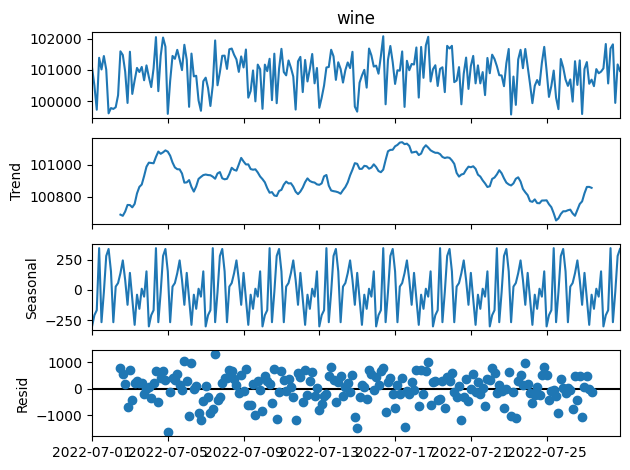

In [ ]:
stl_data = seasonal_decompose(data_test['wine'])
_= stl_data.plot()

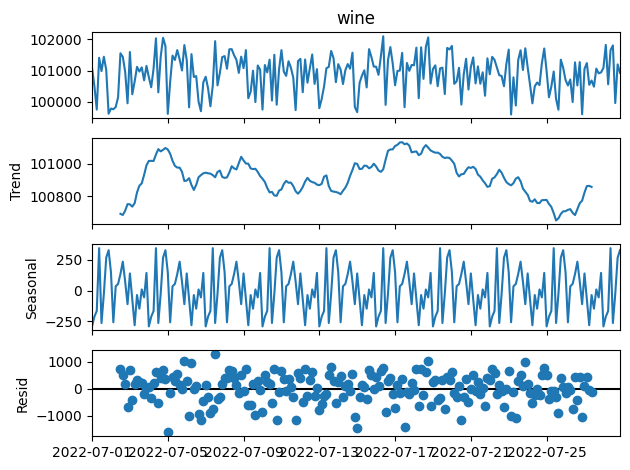

In [ ]:
stl_data = seasonal_decompose(data_test_mean['wine'])
_= stl_data.plot()

### ARIMA

Стационарность:

In [ ]:
kpss(data_test_mean['wine'], nlags='legacy')

(0.0957987345144134,
 0.1,
 15,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

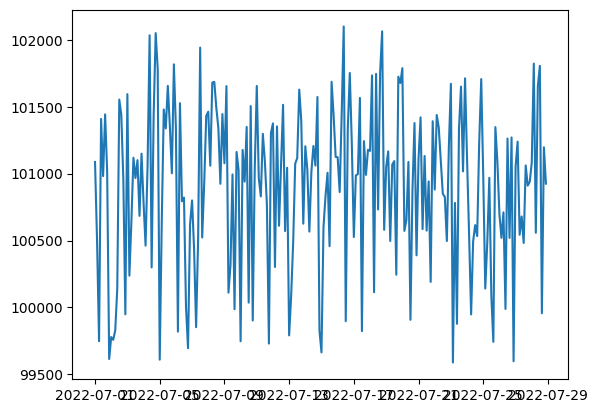

In [ ]:
plt.plot(data_test_mean['wine'])

Для полученного ряда гипотеза стационарности не отвергается

Посмотрим на ACF и PACF полученного ряда:

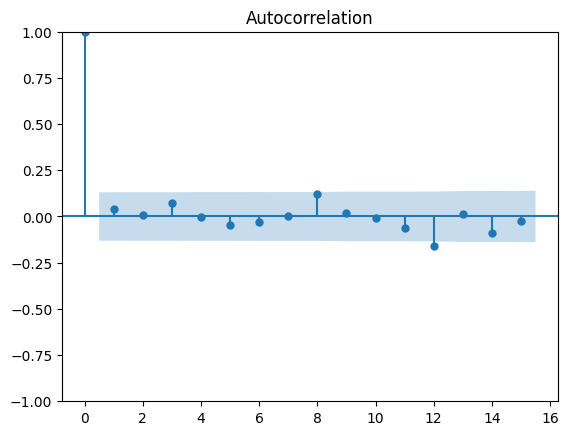

In [ ]:
plot_acf(data_test_mean['wine'], lags=15)

plt.show()

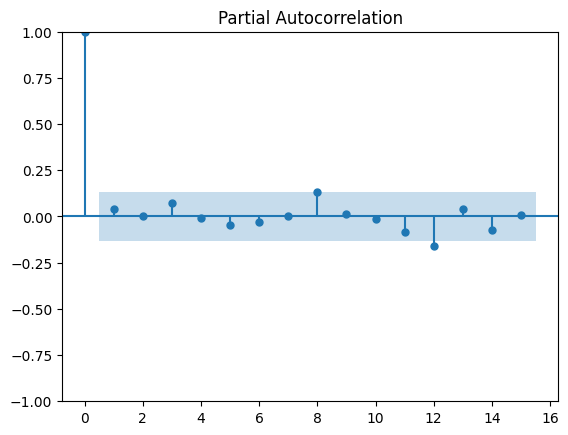

In [ ]:
plot_pacf(data_test_mean['wine'], lags=15)

plt.show()

На ACF и PACF значимы лаги 4. Будем искать модель, оптимальную по AICc, в окрестности ARIMA(4,1,1)

In [ ]:
dict_ = {}
for i in range(3, 6):
    for j in range(1, 4):
        for k in range(1, 4):
            order = (i,j,k)
            try:
                arima = ARIMA(data['wine'].values, order=order).fit()
                dict_[order] = arima.aic
            except:
                pass

In [ ]:
dict_ = {y:x for x,y in dict}

In [ ]:
max(dict, key=dict.get)

AttributeError: ignored

In [ ]:
dict_sx = {}
for i in range(5, 15):
    for j in range(0, 3):
        for k in range(0, 3):
            order = (i,j,k)
            sorder = (1, 1, 1, 8)
            try:
                arima = SARIMAX(data_test_mean['wine'].values, order=order, seasonal_order=sorder).fit()
                dict_sx[(order, sorder)] = arima.aic
            except:
                pass

In [ ]:
best = min(dict_sx, key=dict_sx.get)
best

((7, 0, 2), (1, 1, 1, 8))

# Best_model

In [ ]:
best_model = SARIMAX(test_month, order=(2, 0, 2), seasonal_order=(1, 1, 1, 24)).fit()

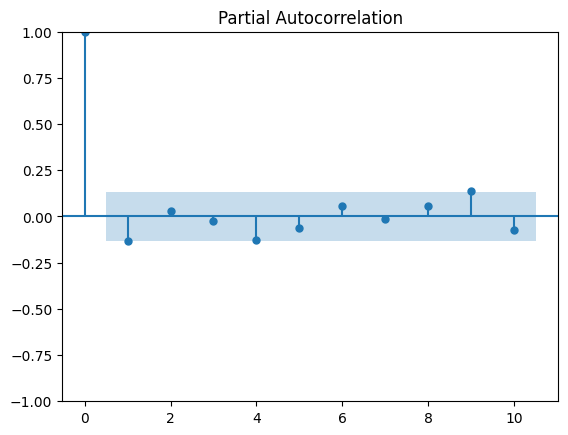

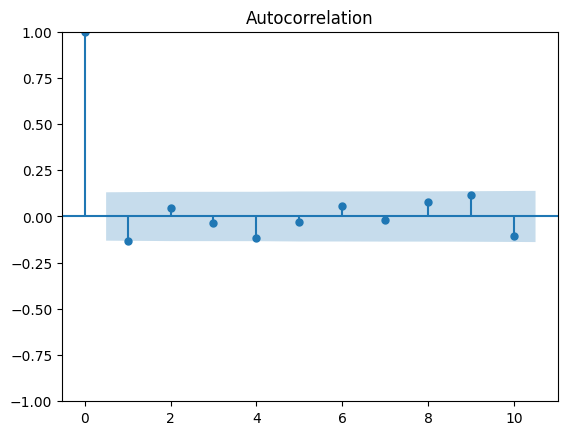

In [ ]:
plot_pacf(test_month, lags=10)
plot_acf(test_month, lags=10)

plt.show()

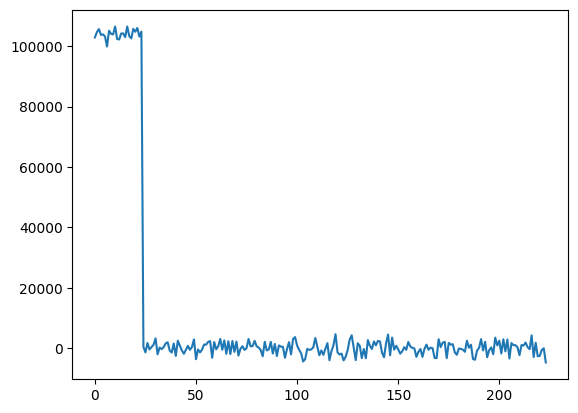

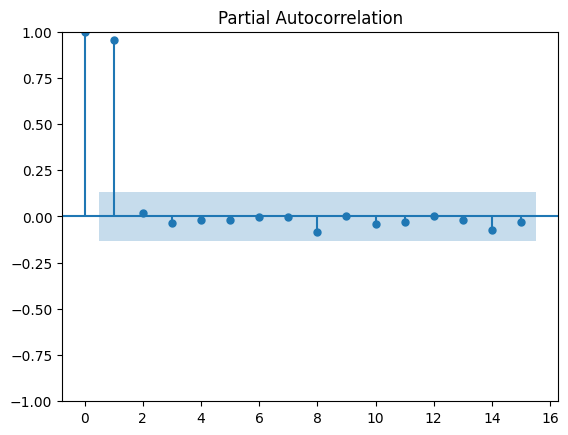

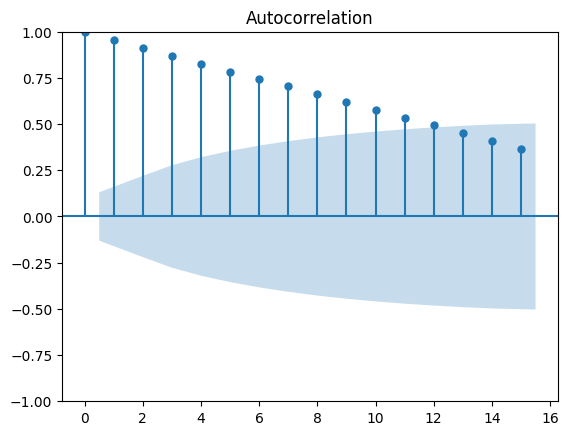

In [ ]:
plt.plot(best_model.resid)
plot_pacf(best_model.resid, lags=15)
plot_acf(best_model.resid, lags=15)

plt.show()

In [ ]:
test_month = []
for i in range(224):
    test_month.append(data[17][607][i])
test_month = np.array(test_month)

test_month_mean = []
for i in range(224):
    test_month_mean.append(data_mean[17][607][i])
test_month_mean = np.array(test_month_mean)

predicted=99823.736950, expected=102525.731250
predicted=101007.243625, expected=99055.487500
predicted=101543.197289, expected=101493.006250
predicted=100943.728137, expected=99316.000000
predicted=101368.621302, expected=103299.931250
predicted=100646.181404, expected=99073.706250
predicted=101499.723304, expected=100670.525000
predicted=101125.551951, expected=100504.787500
predicted=100087.085735, expected=103373.525000
predicted=100141.418577, expected=100044.587500
predicted=101181.025798, expected=98136.137500
predicted=101073.868845, expected=100478.443750
predicted=100833.485095, expected=99507.887500
predicted=100369.919416, expected=103348.225000
predicted=100343.046773, expected=99716.737500
predicted=100987.721890, expected=102876.925000
predicted=100740.992848, expected=102871.950000
predicted=100342.323444, expected=99038.112500
predicted=101283.690152, expected=100251.581250
predicted=101221.530264, expected=99990.075000
predicted=100767.015924, expected=99138.968750
pr

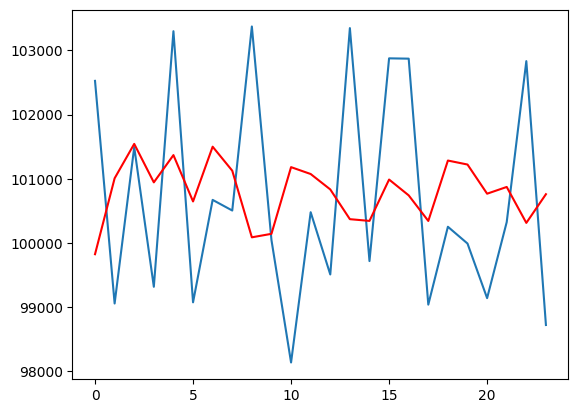

In [ ]:
test_month = []
for i in range(224):
    test_month.append(data[17][607][i])
test_month = np.array(test_month)

test_month_mean = []
for i in range(224):
    test_month_mean.append(data_mean[17][607][i])
test_month_mean = np.array(test_month_mean)

from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# split into train and test sets
D_mean = test_month_mean
D = test_month
train, test = D_mean[0:200], D[200:224]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = SARIMAX(history, order=(4, 0, 2), seasonal_order=(1, 0, 1, 8), enforce_stationarity=False).fit()
    output = model.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# evaluate forecasts
mae = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

[100938.15689134 101386.4236335  100681.65350143 100912.23251234
 100413.17109237 100571.63854784 100856.49289957 100811.63053691
 101260.03790363 101054.3160796  100789.83557615 100696.65485752
 100811.84703329 100593.13885511 100600.41916024 100420.31974736
 101007.46889429 101019.69115114 101109.47890653 101043.21013926
 100603.18729812 100962.05506091 100277.35290081 100676.66182529]
Test MAE: 517.040


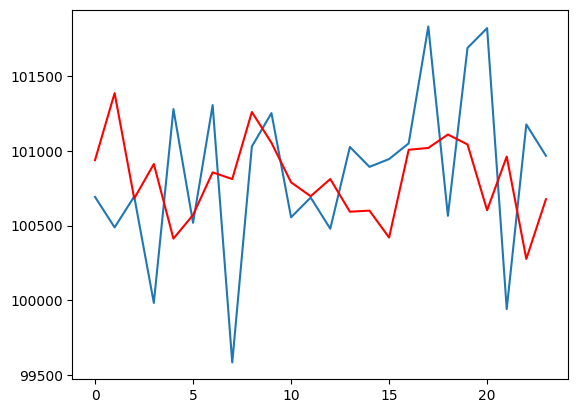

In [ ]:
test_month = []
for i in range(224):
    test_month.append(data[100][100][i])
test_month = np.array(test_month)

test_month_mean = []
for i in range(224):
    test_month_mean.append(data_mean[100][100][i])
test_month_mean = np.array(test_month_mean)

from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# split into train and test sets
D_mean = test_month_mean
D = test_month
train, test = D_mean[0:200], D[200:224]
predictions = list()
# walk-forward validation
model = SARIMAX(train, order=(6, 0, 6), seasonal_order=(6, 0, 0, 9), enforce_stationarity=False).fit()
output = model.forecast(24)
print(output)
#yhat = output[0]
#predictions.append(yhat)
#obs = test[t]
#history.append(obs)
#print('predicted=%f, expected=%f' % (yhat, obs))
## evaluate forecasts
mae = mean_absolute_error(test, output)
print('Test MAE: %.3f' % mae)
## plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(output, color='red')
pyplot.show()

In [ ]:
stl_data = seasonal_decompose(test_month)
_= stl_data.plot()

ValueError: ignored

[ 99279.28805714 100169.38201983  98498.09933588 101062.24424172
 100341.91428248 102567.09065485  99326.74997594  99983.03399753
 101602.23680015  99585.30561098  99719.8199294  100857.96757536]
Test MAE: 1801.016


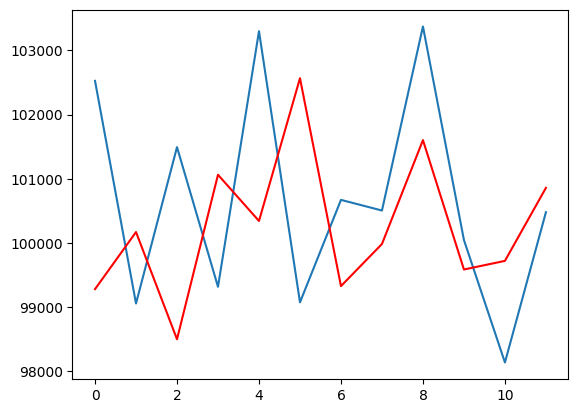

In [ ]:
test_month = []
for i in range(224):
    test_month.append(data[17][607][i])
test_month = np.array(test_month)

test_month_mean = []
for i in range(224):
    test_month_mean.append(data_mean[17][607][i])
test_month_mean = np.array(test_month_mean)

from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# split into train and test sets
D_mean = test_month_mean
D = test_month
train, test = D_mean[0:200], D[200:212]
# walk-forward validation
model = SARIMAX(train, order=(8, 0, 1), seasonal_order=(1, 1, 1, 24), enforce_stationarity=False).fit()
output = model.forecast(12)
print(output)
#yhat = output[0]
#predictions.append(yhat)
#obs = test[t]
#history.append(obs)
#print('predicted=%f, expected=%f' % (yhat, obs))
## evaluate forecasts
mae = mean_absolute_error(test, output)
print('Test MAE: %.3f' % mae)
## plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(output, color='red')
pyplot.show()

[100301.6987229  100920.39897342  98953.08622373 100428.80940931
 100968.07518997 102519.13310796 101317.61347217 101573.73404043
 100866.0156619  100050.11887574 100560.70069051 102572.33009624
  99862.56384048 101424.65186527  99910.79981939 101377.56916196
 101612.49458448 101021.14294596  99182.98911945 101250.52786763
  99813.49501698  99986.60697155 102910.74384421 101507.54035262
 100033.21735777  99961.94718818  99722.87514933 100333.88064402
 100394.88105108 102635.12110163 100247.92439636 102450.42214842
 101029.85412116  99805.77032125 101347.86765658 102690.73071783
 100383.48880492 102130.12460011  99411.13233745 100727.67520043
 102143.12963793 101933.27473019  98638.95257848 102226.1494213
  99522.73890364 100240.18066824 102922.10646043 100952.41375025
 100160.84910227 100418.27163698  99357.29664151 100377.16336045
 100668.83411588 102581.31426396 100757.91520984 102031.35419224
 100951.89438832  99921.23463802 100972.01496508 102633.70190024
 100133.32735122 101793.21

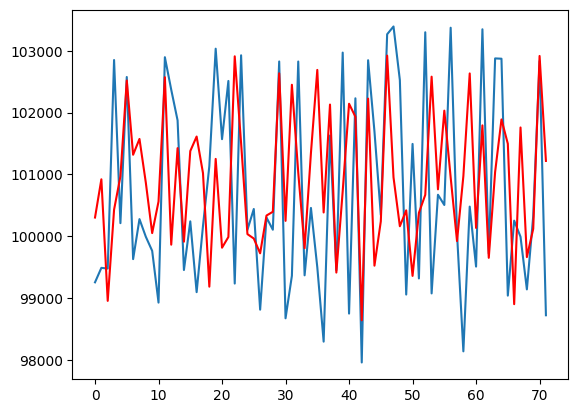

In [ ]:
test_month = []
for i in range(224):
    test_month.append(data[17][607][i])
test_month = np.array(test_month)

test_month_mean = []
for i in range(224):
    test_month_mean.append(data_mean[17][607][i])
test_month_mean = np.array(test_month_mean)

from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# split into train and test sets
D_mean = test_month_mean
D = test_month
train, test = D_mean[0:152], D[152:224]
# walk-forward validation
model = SARIMAX(train, order=(8, 0, 3), seasonal_order=(1, 1, 1, 24), enforce_stationarity=False).fit()
output = model.forecast(72)
print(output)
#yhat = output[0]
#predictions.append(yhat)
#obs = test[t]
#history.append(obs)
#print('predicted=%f, expected=%f' % (yhat, obs))
## evaluate forecasts
mae = mean_absolute_error(test, output)
print('Test MAE: %.3f' % mae)
## plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(output, color='red')
pyplot.show()

In [ ]:
test_month = []
for i in range(224):
    test_month.append(data[17][607][i])
test_month = np.array(test_month)

test_month_mean = []
for i in range(224):
    test_month_mean.append(data_mean[17][607][i])
test_month_mean = np.array(test_month_mean)

dict_sx = {}
for i in [2, 6, 8]:
    for j in [2, 6, 8]:
        for k in [6, 8, 12, 24]:
            order = (i,0,j)
            sorder = (1, 0, 0, 9)
            try:
                arima = SARIMAX(test_month_mean[:200], order=order, seasonal_order=sorder).fit()
                dict_sx[(order, sorder)] = arima.aic
            except:
                pass

In [ ]:
best = min(dict_sx, key=dict_sx.get)
best

((2, 0, 2), (1, 0, 0, 24))

[ 99971.21904145 101237.03881791 101012.11821713 100139.0891538
 101156.40586066 100960.17496407 100260.43778685 101100.16050158
 100922.48116025 100350.30214948 101059.47154101 100897.03135071
 100415.52478912 101031.72820148 100878.83596757 100464.3688701
 101011.94803087 100867.17323374 100500.11588432 100999.05035523
 100859.1583732  100527.35143783 100990.18798422 100854.63343345]
Test MAE: 456.657


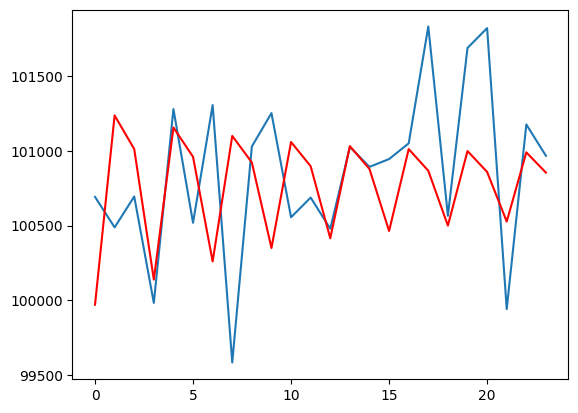

In [ ]:
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

# split into train and test sets
D_mean = data_test_mean['wine'].values
D = data_test['wine'].values
train, test = D_mean[0:200], D[200:224]
history = [x for x in train]
predictions = list()
# walk-forward validation
model = SARIMAX(history, order=(2, 0, 2), seasonal_order=(1, 1, 1, 3))
model_fit = model.fit()
output = model_fit.forecast(24)
print(output)
#yhat = output[0]
#predictions.append(yhat)
#obs = test[t]
#history.append(obs)
#print('predicted=%f, expected=%f' % (yhat, obs))
## evaluate forecasts
mae = mean_absolute_error(test, output)
print('Test MAE: %.3f' % mae)
## plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(output, color='red')
pyplot.show()

Q-Q plot:

ShapiroResult(statistic=0.25626999139785767, pvalue=4.7002630247120916e-29)


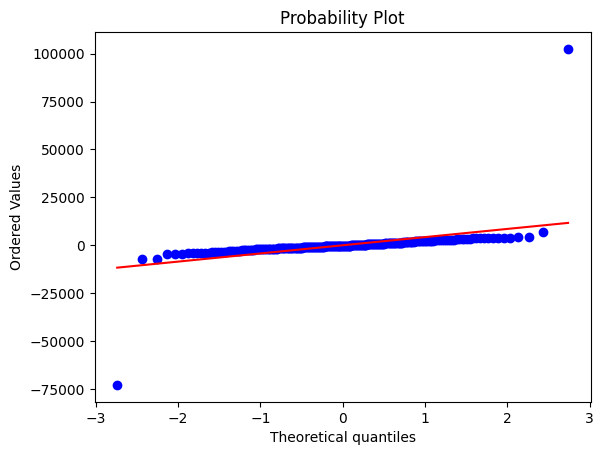

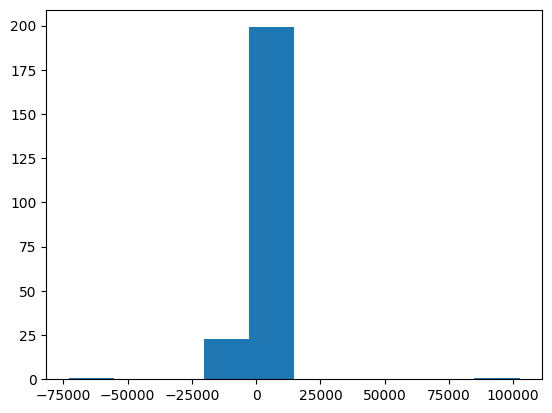

In [ ]:
_ = st.probplot(best_model.resid, plot=plt)
print (st.shapiro(best_model.resid))
plt.show()
plt.hist(best_model.resid)

plt.show()

In [ ]:
arima = SARIMAX(data['wine'].values[:-8], order=(3,1,1), seasonal_order=(1,1,1,8)).fit()
predicted = arima.predict(0, data.shape[0])

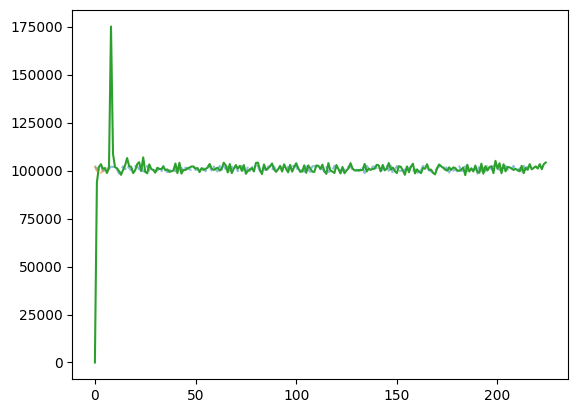

In [ ]:
plt.plot(data['wine'].values[:-8], alpha=0.5, ls='--')
plt.plot(data['wine'].values[-8:], alpha=0.5, ls='--')
plt.plot(predicted)

plt.show()

In [ ]:
arima = SARIMAX(data['wine'].values[:-8], order=(3,1,1), seasonal_order=(1,1,1,8)).fit()
predicted = arima.predict(data.shape[0]-8, data.shape[0]-1, dynamic=True)

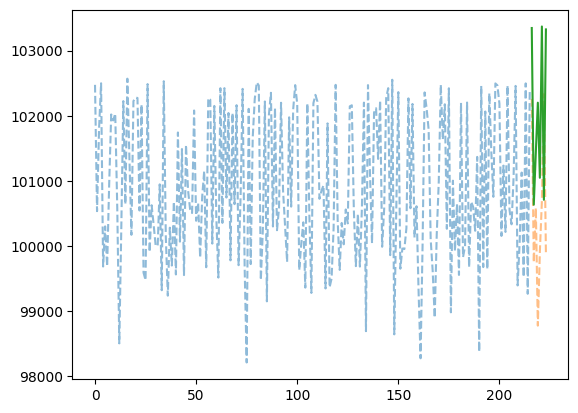

In [ ]:
plt.plot(data['wine'].values[:-8], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-8]), len(data['wine'])), data['wine'].values[-8:], alpha=0.5, ls='--')
plt.plot(range(len(data['wine'].values[:-8]), len(data['wine'])), predicted)

plt.show()

# SARIMAX

In [ ]:
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

mae_sum = 0
dates = pd.date_range(start="2022-07-01T00",end="2022-07-28T21", freq = '3H')

for i in range(100, 105):
    for j in range(100, 105):
        test_month = []
        #test_month_mean = []
        for k in range(224):
            test_month.append(data[i][j][k])
            #test_month_mean.append(data_mean[i][j][k])
        test_month = np.array(test_month)
        #test_month_mean = np.array(test_month_mean)

        data_test = pd.DataFrame(test_month, index=dates, columns=['wine']).set_index(pd.DatetimeIndex(dates))
        #data_test_mean = pd.DataFrame(test_month_mean, index=dates, columns=['wine']).set_index(pd.DatetimeIndex(dates))

        # split into train and test sets
        D_mean = data_test['wine'].values
        D = data_test['wine'].values
        train, test = D_mean[0:200], D[200:224]
        history = [x for x in train]
        predictions = list()
        # walk-forward validation
        model = SARIMAX(history, order=(2, 0, 2), seasonal_order=(1, 1, 1, 3))
        model_fit = model.fit()
        output = model_fit.forecast(24)
        #print(output)
        #yhat = output[0]
        #predictions.append(yhat)
        #obs = test[t]
        #history.append(obs)
        #print('predicted=%f, expected=%f' % (yhat, obs))
        ## evaluate forecasts
        mae = mean_absolute_error(test, output)
        mae_sum+=mae
        print('Test MAE: %.3f' % mae)
        ## plot forecasts against actual outcomes
        #pyplot.plot(test)
        #pyplot.plot(output, color='red')
        #pyplot.show()

In [ ]:
print(mae_sum/25)

443.13131567075527
